In [71]:
import pandas as pd
import pickle as pkl
import os


def get_evidence_df(ann_folder):
    rows = {}
    for filename in os.listdir(ann_folder):
        with open(os.path.join(ann_folder, filename), 'rb') as f:
            d = pkl.load(f)
            instance_data = next(iter(d.values()))
            anns = instance_data['model_anns']
            if len(anns) > 0:
                assert len(anns) == 1
                model_type = next(iter(anns.keys()))
                anns['model_type'] = model_type
                model_anns = anns[model_type]
                if len(model_anns) > 0:
                    assert len(model_anns['sort_by_model_order']) == 1
                    sort_type = model_anns['sort_by_model_order'][0]
                    anns['sort_type'] = sort_type
                    del model_anns['sort_by_model_order']
                    model_anns['evidence_anns'] = model_anns['evidence_anns'][sort_type]
                    anns.update(model_anns)
                del anns[model_type]
            del instance_data['model_anns']
            instance_data.update(instance_data['info'])
            del instance_data['info']
            instance_data.update(anns)
            rows.update(d)
    return pd.DataFrame(rows).transpose().sort_index()


In [87]:
df = get_evidence_df('/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-29-23/annotations/val2/Andrea/')
df

,obs,timestep,num_reports,instance,time_for_initial_assesment,seen_targets,option_likelihood_anns,max_timesteps,true_positives,current_targets,...,instance_index,model_type,sort_type,prediction_aligns,evidence_anns,options,selected_options,option_likelihood_anns2,concluding_notes,invalid_instance_notes
0,"{'options': 'option,type cancer,diagnosis pneu...",1,26,"val2 Instance 50 (patient 11755, 122 reports)",168.272657,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",19,None,"{pulmonary edema, pneumonia}",...,49,llm_evidence,LLM Confidence,Yes,{10: {'cancer': {'relevance': '1 - Weak Correl...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN
1,"{'options': 'option,type cancer,diagnosis pneu...",1,42,"val2 Instance 51 (patient 7470, 53 reports)",189.534721,{pulmonary edema (diagnosis)},NaN,21,None,{},...,50,llm_evidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,"{'options': 'option,type cancer,diagnosis pneu...",1,1,"val2 Instance 52 (patient 83375, 8 reports)",24.683878,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",7,None,{pulmonary edema},...,51,llm_evidence,LLM Confidence,No,"{1: {'cancer': {'relevance': '0 - Not Useful',...","[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN
3,"{'options': 'option,type cancer,diagnosis pneu...",1,2,"val2 Instance 53 (patient 94023, 4 reports)",29.90608,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",3,None,{},...,52,llm_evidence,LLM Confidence,Yes,"{1: {'cancer': {'relevance': '0 - Not Useful',...","[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN
4,"{'options': 'option,type cancer,diagnosis pneu...",1,2,"val2 Instance 54 (patient 26310, 32 reports)",46.365206,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",3,None,{pulmonary edema},...,53,llm_evidence,Sort by MSE with the bias logits,No,"{0: {'cancer': {'relevance': '0 - Not Useful',...","[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN
5,"{'options': 'option,type cancer,diagnosis pneu...",1,24,"val2 Instance 55 (patient 5255, 25 reports)",158.251378,{cancer (diagnosis)},NaN,1,None,{cancer},...,54,llm_evidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [75]:
df.iloc[0].evidence_anns

{10: {'cancer': {'relevance': '1 - Weak Correlation', 'impact': 'Yes'},
  'pneumonia': {'relevance': '1 - Weak Correlation', 'impact': 'Yes'},
  'pulmonary edema': {'relevance': '1 - Weak Correlation', 'impact': 'Yes'},
  'evidence_was_seen': 'Yes',
  'notes': 'Only one piece of relevant evidence because huge gap in the medical record between recent report and past reports.',
  'evidence': {'score': '0.96',
   'evidence': "The liver is nodular and coarse in echotexture, consistent with patient's history of known cirrhosis. The gallbladder wall is thickened, with a dependent gallstone within it. A moderate amount of",
   'query': 'cancer (diagnosis)',
   'day': -387,
   'report_number': '20'},
  'sorted_idx': 0,
  'evidence_distribution': [2.884256362915039,
   -2.276189088821411,
   -1.170615315437317]}}

In [95]:
from collections import defaultdict
def get_processed_annotations(df):
    new_rows = []
    for i, row in df.iterrows():
        new_rows.append({
            'instance_index': row['instance_index'],
            'num_reports': row['num_reports'],
            'model_type': row['model_type'],
            'sort_type': row['sort_type'],
            'prediction_aligns': row['prediction_aligns'],
            'time_for_initial_assesment': row['time_for_initial_assesment'],
        })
        if row['options'] == row['options']:
            for condition in row['options']:
                condition = condition.split(' (')[0]
                new_rows[-1][condition + ' in future'] = condition in row['future_true_positives']
            evidence_anns = sorted([{'idx': k, **v} for k, v in row['evidence_anns'].items()], key=lambda x: x['sorted_idx'])
            new_evidence_anns = defaultdict(lambda: [])
            new_rows[-1]['num_annotated_evidence'] = len(evidence_anns)
            for x in evidence_anns:
                evidence_info = x['evidence']
                for k, v in evidence_info.items():
                    if k == 'evidence':
                        continue
                    new_evidence_anns[k].append(v)
                new_evidence_anns['evidence_was_seen'].append(
                    x['evidence_was_seen'] if 'evidence_was_seen' in x.keys() else None)
                for condition in row['options']:
                    condition = condition.split(' (')[0]
                    new_evidence_anns[condition + ' relevance'].append(int(
                        x[condition]['relevance'].split()[0]))
                    new_evidence_anns[condition + ' impact'].append(
                        x[condition]['impact'] if 'impact' in x[condition].keys()
                        else None)
            new_rows[-1].update(new_evidence_anns)
        if row['option_likelihood_anns'] == row['option_likelihood_anns']:
            new_rows[-1].update({k.split(' (')[0]: v for k, v in row['option_likelihood_anns'].items()})
            new_rows[-1].update({k.split(' (')[0] + '(changed)': v for k, v in row['option_likelihood_anns2'].items() if v != row['option_likelihood_anns'][k]})
    new_df = pd.DataFrame(new_rows)
    return new_df


In [96]:
processed_df = get_processed_annotations(df)
processed_df

,instance_index,num_reports,model_type,sort_type,prediction_aligns,time_for_initial_assesment,cancer in future,pneumonia in future,pulmonary edema in future,num_annotated_evidence,...,evidence_was_seen,cancer relevance,cancer impact,pneumonia relevance,pneumonia impact,pulmonary edema relevance,pulmonary edema impact,cancer,pneumonia,pulmonary edema
0,49,26,llm_evidence,LLM Confidence,Yes,168.272657,False,True,True,1.0,...,[Yes],[1],[Yes],[1],[Yes],[1],[Yes],Unlikely,Somewhat likely,Somewhat likely
1,50,42,llm_evidence,NaN,NaN,189.534721,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51,1,llm_evidence,LLM Confidence,No,24.683878,False,False,True,2.0,...,"[Yes, None]","[0, 0]","[None, None]","[1, 0]","[No, None]","[1, 0]","[No, None]",Unlikely,Unlikely,Unlikely
3,52,2,llm_evidence,LLM Confidence,Yes,29.906080,False,False,False,3.0,...,"[None, None, None]","[0, 0, 0]","[None, None, None]","[0, 0, 0]","[None, None, None]","[0, 0, 0]","[None, None, None]",Unlikely,Unlikely,Somewhat likely
4,53,2,llm_evidence,Sort by MSE with the bias logits,No,46.365206,False,False,True,1.0,...,[Yes],[0],[None],[1],[Yes],[1],[Yes],Unlikely,Unlikely,Unlikely
5,54,24,llm_evidence,NaN,NaN,158.251378,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
processed_df.keys()

Index(['instance_index', 'num_reports', 'model_type', 'sort_type',
       'prediction_aligns', 'time_for_initial_assesment', 'cancer in future',
       'pneumonia in future', 'pulmonary edema in future',
       'num_annotated_evidence', 'score', 'query', 'day', 'report_number',
       'evidence_was_seen', 'cancer relevance', 'cancer impact',
       'pneumonia relevance', 'pneumonia impact', 'pulmonary edema relevance',
       'pulmonary edema impact', 'cancer', 'pneumonia', 'pulmonary edema'],
      dtype='object')

<Axes: xlabel='num_reports', ylabel='time_for_initial_assesment'>

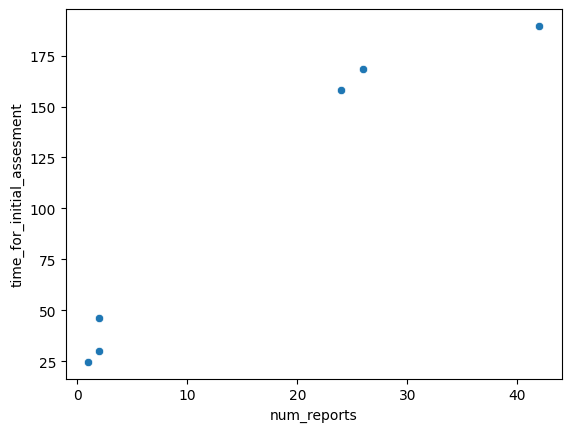

In [98]:
import seaborn as sns
sns.scatterplot(data=processed_df, x='num_reports', y='time_for_initial_assesment')

In [107]:
from collections import Counter
instance_counts = []
for i, row in processed_df.iterrows():
    instance_counts.append(Counter())
    relevance_keys = [k for k in row.keys() if k.endswith(' relevance')]
    if row[relevance_keys[0]] == row[relevance_keys[0]]:
        for x in zip(*[row[k] for k in relevance_keys]):
            instance_counts[-1][max(x)] += 1
instance_counts = pd.DataFrame(instance_counts)
instance_counts

,1,0
0,1.0,NaN
1,NaN,NaN
2,1.0,1.0
3,NaN,3.0
4,1.0,NaN
5,NaN,NaN


In [112]:
from collections import Counter
query_counts = defaultdict(lambda : Counter())
for i, row in processed_df.iterrows():
    relevance_keys = [k for k in row.keys() if k.endswith(' relevance')]
    if row[relevance_keys[0]] == row[relevance_keys[0]]:
        for x in zip(row['query'], *[row[k] for k in relevance_keys]):
            query_counts[x[0]][max(x[1:])] += 1
query_counts = pd.DataFrame(query_counts).transpose()
query_counts

,1,0
cancer (diagnosis),1.0,NaN
pulmonary edema (diagnosis),2.0,1.0
pneumonia (diagnosis),NaN,1.0
tiredness (risk factor),NaN,2.0
